In [1]:
# # Mount the Google Drive

# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Load packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Preprocessing and tuning packages 
from sklearn.preprocessing import StandardScaler

# Modelling packages 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Evaluation packages 
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV, cross_val_score

In [4]:
train = pd.read_csv('data/train_data_encoded.csv')
valid = pd.read_csv('data/validation_data_encoded.csv')
test = pd.read_csv('data/test_data_encoded.csv')

Now I will try hyperparameter tuning to find the best set of parameters for the 3 chosen algorithms. I will also implement the final model on the Test (Holdout) dataset and see how we performed overall.

In [ ]:
# Get Train, Validation and Test datasets

X_train = train.drop(columns=['target'])
y_train = train['target']

X_valid = valid.drop(columns=['target'])
y_validation = valid['target']

X_test = test.drop(columns=['target'])
y_test = test['target']

# Scaling

The dataset is already encoded, however I need to scale the values before implementing any model.

In [ ]:
scaler = StandardScaler()

# Fit on the training dataset
scaler.fit(X_train)

# Transform the training and validation datasets
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning

I would prefer applying 10 fold cross validation but due to time constraints I will go with 5 fold cross validation. Also, there are multiple parameters to tune but I will tune only a few so I have more time for other experiments if possible.

## Logistic Regression

While implemeting the Logistic regression we chose the inverse of intensity of regularization(Ridge) we intend to apply. There is a coefficient C which determines that. I will try couple of values of C and find the best through crossvalidation.

In [ ]:
# Parameters to tune 
parameters = {
    'C': [0.001, 0.01, 0.1, 1.0, 10, 100]
}
parameters

{'C': [0.001, 0.01, 0.1, 1.0, 10, 100]}

In [ ]:
# Model
lr = LogisticRegression(random_state=42,  class_weight='balanced')
cv_lr = GridSearchCV(lr, parameters, cv=5, n_jobs = -1 )

# Find best parameters
cv_lr.fit(X_train_scaled, y_train)
print('The best parameters are: \n', cv_lr.best_params_)

The best parameters are: 
 {'C': 100}


In [ ]:
# Retrain model with tuned parameters

lr_model = LogisticRegression(
    random_state=42, 
    class_weight='balanced',
    C=cv_lr.best_params_['C']) 

lr_model.fit(X_train_scaled, y_train)

LogisticRegression(C=100, class_weight='balanced', random_state=42)

In [ ]:
# Model Evaluation  
y_predict_train = lr_model.predict_proba(X_train_scaled)
y_predict_valid = lr_model.predict_proba(X_validation_scaled)
y_predict_test = lr_model.predict_proba(X_test_scaled)

train_score_lr = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_lr = roc_auc_score(y_validation, y_predict_valid[:,1])
test_score_lr = roc_auc_score(y_test, y_predict_test[:,1])
print("Training ROC-AUC score of Logistic Regression model: ", train_score_lr)
print("Validation ROC-AUC score of Logistic Regression model: ", valid_score_lr)
print("Test ROC-AUC score of Logistic Regression model: ", test_score_lr)

Training ROC-AUC score of Logistic Regression model:  0.7987362355957504
Validation ROC-AUC score of Logistic Regression model:  0.7872505209816545
Test ROC-AUC score of Logistic Regression model:  0.7896226109634443


## Random Forest

There are multiple parameters we can tune in Random Forest eg. max features, n estimators, depth of the tree. We noticed above how RF is clearly overfitting.

In [ ]:
# Parameters to tune 
n_estimators = np.arange(0,1001,50)[1:]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)

parameters = {
    'max_features': max_features,
    'n_estimators': n_estimators,
    'max_depth': max_depth
}
parameters

{'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 100, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
         600,  650,  700,  750,  800,  850,  900,  950, 1000])}

In [ ]:
# Model
rf = RandomForestClassifier(random_state=42)
cv_rf = RandomizedSearchCV(rf, parameters, cv=5)

# Find best parameters
cv_rf.fit(X_train_scaled, y_train)
print('The best parameters are: \n', cv_rf.best_params_)

The best parameters are: 
 {'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 5}


In [ ]:
# Retrain model with tuned parameters

rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators =  cv_rf.best_params_['n_estimators'], 
    max_features =  cv_rf.best_params_['max_features'],
    max_depth =  cv_rf.best_params_['max_depth'],
) 

rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42)

In [ ]:
# Model Evaluation 
y_predict_train = rf_model.predict_proba(X_train_scaled)
y_predict_valid = rf_model.predict_proba(X_validation_scaled)
y_predict_test = rf_model.predict_proba(X_test_scaled)

train_score_rf = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_rf = roc_auc_score(y_validation, y_predict_valid[:,1])
test_score_rf = roc_auc_score(y_test, y_predict_test[:,1])
print("Training ROC-AUC score of Random Forest model: ", train_score_rf)
print("Validation ROC-AUC score of Random Forest model: ", valid_score_rf)
print("Test ROC-AUC score of Random Forest model: ", test_score_rf)

Training ROC-AUC score of Random Forest model:  0.8025943527556871
Validation ROC-AUC score of Random Forest model:  0.7878348787569898
Test ROC-AUC score of Random Forest model:  0.787706083378222


## XGBoost

Due to time constraints I will tune some important parameters only.

In [ ]:
# Parameters to tune 
parameters = {
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [3, 4, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7]
}
parameters

{'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1, 0.3],
 'max_depth': [3, 4, 6, 8, 10],
 'min_child_weight': [1, 3, 5, 7],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [ ]:
# Model
xgbc = xgb.XGBClassifier(random_state = 42, verbosity=0)
cv_xgb = RandomizedSearchCV(xgbc, parameters, cv=5)

# Find best parameters
cv_xgb.fit(X_train_scaled, y_train)

print('The best parameters are: \n', cv_xgb.best_params_)

The best parameters are: 
 {'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.025}


In [ ]:
# Retrain model with tuned parameters

xgb_model = xgb.XGBClassifier(
    random_state=42, 
    learning_rate=cv_xgb.best_params_['learning_rate'],
    n_estimators=cv_xgb.best_params_['n_estimators'],
    max_depth=cv_xgb.best_params_['max_depth'],
    min_child_weight=cv_xgb.best_params_['min_child_weight'], 
    verbosity=0
) 

xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(learning_rate=0.025, max_depth=6, random_state=42, verbosity=0)

In [ ]:
# Model Evaluation
y_predict_train = xgb_model.predict_proba(X_train_scaled)
y_predict_valid = xgb_model.predict_proba(X_validation_scaled)
y_predict_test = xgb_model.predict_proba(X_test_scaled)

train_score_xgb = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_xgb = roc_auc_score(y_validation, y_predict_valid[:,1])
test_score_xgb = roc_auc_score(y_test, y_predict_test[:,1])
print("Training ROC-AUC score of XGBoost model: ", train_score_xgb)
print("Validation ROC-AUC score of XGBoost model: ", valid_score_xgb)
print("Test ROC-AUC score of XGBoost model: ", test_score_xgb)

Training ROC-AUC score of XGBoost model:  0.8251927585680969
Validation ROC-AUC score of XGBoost model:  0.7941034591052688
Test ROC-AUC score of XGBoost model:  0.7918614542767912


# Final Results

In [ ]:
Model_comparison = {
    'model':['Logistic Regression', 'Random Forest',  'XGBoost' ],
    'Train ROC-AUC score':[train_score_lr,  train_score_rf,  train_score_xgb ],
    'Validation ROC-AUC score':[valid_score_lr, valid_score_rf,  valid_score_xgb],
    'Test ROC-AUC score':[test_score_lr, test_score_rf,  test_score_xgb]
}

pd.DataFrame(Model_comparison)

,model,Train ROC-AUC score,Validation ROC-AUC score,Test ROC-AUC score
0,Logistic Regression,0.798736,0.787251,0.789623
1,Random Forest,0.802594,0.787835,0.787706
2,XGBoost,0.825193,0.794103,0.791861


Finally, Random Forest has shown great improvement, it is not overfitting like it was without hyperparameter tuning. All three models now look relatively stable. There probably is some overfitting in XGBoost and Random Forest but XGBoost has a better AUC than Logistic regression or Random Forest. We can use above models for future predictions.

Final ROC curves for Logistic regression and XGBoost. ROC AUC curve plots reference: https://www.projectpro.io/recipes/plot-roc-curve-in-python

In [ ]:
# Calculate inputs for ROC curve Logistic Regression
probs_lr = lr_model.predict_proba(X_test_scaled)
preds_lr = probs_lr[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, preds_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Calculate inputs for ROC curve XGBoost
probs_xgb = xgb_model.predict_proba(X_test_scaled)
preds_xgb = probs_xgb[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, preds_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate inputs for ROC curve Random Forest
probs_rf = rf_model.predict_proba(X_test_scaled)
preds_rf = probs_rf[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


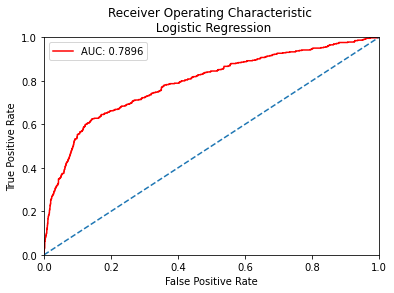

In [ ]:
# ROC Curve plot 
plt.title('Receiver Operating Characteristic \n Logistic Regression')
plt.plot(fpr_lr, tpr_lr, 'r', label = 'AUC: '+str(round(roc_auc_lr,4)))
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

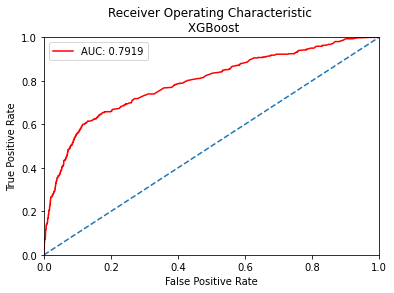

In [ ]:
# ROC Curve plot 
plt.title('Receiver Operating Characteristic \n XGBoost')
plt.plot(fpr_xgb, tpr_xgb, 'r', label = 'AUC: '+str(round(roc_auc_xgb,4)))
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

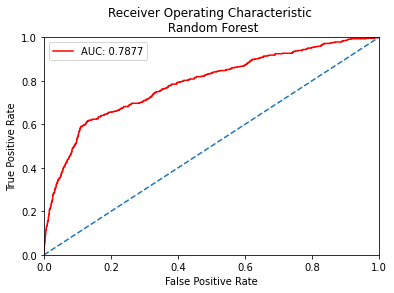

In [ ]:
# ROC Curve plot 
plt.title('Receiver Operating Characteristic \n Random Forest')
plt.plot(fpr_rf, tpr_rf, 'r', label = 'AUC: '+str(round(roc_auc_rf,4)))
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# Next Steps 

The overall results look reasonable to me. However there is a scope of further experimentation, below is the list of what I would like to try: <br>
1. Another algorithm that need lot of data and can model non linear hyperplanes pretty well is Neural networks. By making a good choice of activation function, number of hidden layers etc, we might get good results. 
2. I would also like to try SVM with RBF and polynomial kernels which can model non linear planes. These models take time to run and hence I tried only Linear SVM in the previous notebook.
3. Some more work can be done on feature selection. We have many categorical features, Chi square test can be done to see if the observation we have of categories is independent of the target or not.
4. We know there are correlated features, we can try dimensionality reduction and then fit the models. We will loose the intrepretation capabilities but it is something worth trying.
5. Like I mentioned in the EDA we can try undersampling, oversampling to balance the target categories.
6. Compute SHAP values to understand the contribution of each feature to subscription  



# END